# Packages & functions

In [208]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [209]:
# !pip install nose

In [210]:
#from google.colab import drive
#drive.mount('/content/drive')

In [211]:
from tensorflow.keras import models

from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [212]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *

# Data download

## Paths download

In [213]:
assert isdir(DataProperties.train_data_path) == True
assert isdir(DataProperties.test_data_path) == True

In [214]:
train_covid_fnames, train_pn_fnames, train_normal_fnames = get_filenames(
    covid_path = DataProperties.train_covid_path,
    pneumonia_path = DataProperties.train_pneumonia_path,
    normal_path = DataProperties.train_healthy_path
)

test_covid_fnames, test_pn_fnames, test_normal_fnames = get_filenames(
    covid_path = DataProperties.test_covid_path,
    pneumonia_path = DataProperties.test_pneumonia_path,
    normal_path = DataProperties.test_healthy_path
)

In [215]:
train_covid_labels, train_pn_labels, train_normal_labels = get_labels(
    train_covid_fnames,
    train_pn_fnames,
    train_normal_fnames
)

test_covid_labels, test_pn_labels, test_normal_labels = get_labels(
    test_covid_fnames,
    test_pn_fnames,
    test_normal_fnames
)

In [216]:
X_train_val, Y_train_val = getXY(
    train_covid_fnames, train_pn_fnames, train_normal_fnames,
    train_covid_labels, train_pn_labels, train_normal_labels
)

X_test, Y_test = getXY(
    test_covid_fnames, test_pn_fnames, test_normal_fnames,
    test_covid_labels, test_pn_labels, test_normal_labels
)

# Data exploration

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


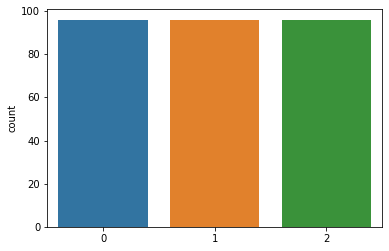

In [217]:
_ = sns.countplot(Y_test)

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


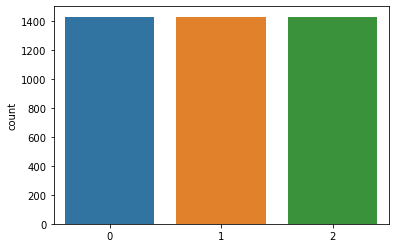

In [218]:
_ = sns.countplot(Y_train_val)

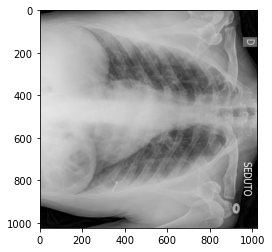

In [219]:
im = load_image(X_train_val[70])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [220]:
def calc_necessary_split(desired_N, directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        print('Searching in : ',base)
        for _ in files:
            total_files += 1
    print(f'Total files: {total_files}')
    return 1 - desired_N / total_files

# We want to use only little data in the beginning, to check if the code works fine
initial_N = 200
dummy_split = calc_necessary_split(
    initial_N,
    directory = DataProperties.train_data_path
)
dummy_split

Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/covid
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/normal
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/pneumonia
Total files: 4287


0.953347329134593

In [223]:
if DataProperties.strategy == 'check':
    split = dummy_split
elif DataProperties.strategy == 'normal':
    split = DatasetParameters.validation_split

train_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = split
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

train_flow = train_generator.flow_from_directory(
    directory = DataProperties.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)

val_flow = train_generator.flow_from_directory(
    directory = DataProperties.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes, 
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'validation',
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

Found 201 images belonging to 3 classes.
Found 4086 images belonging to 3 classes.


In [224]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    # other parameters
)

test_flow = test_generator.flow_from_directory(
    directory = DataProperties.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1
)

Found 288 images belonging to 3 classes.


In [225]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

(32, 300, 300, 3)


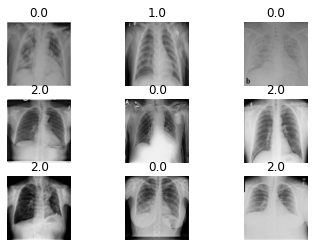

In [226]:
def visualize(batch, labels, n_subplots):
    for i in range(n_subplots): #(batch_size):
        ax = plt.subplot(
            int(np.sqrt(n_subplots)), 
            int(np.sqrt(n_subplots)), 
            i + 1
        )
        plt.imshow(batch[i])
        plt.title(str(labels[i]))
        plt.axis("off")

how_many_to_show = 9
for _ in range(1):
    batch, labels = train_flow.next()
    print(batch.shape)
    assert np.max(batch) <= 1.0
    visualize(batch, labels, how_many_to_show)

In [227]:
# def get_dataset(
#     path,
#     batch_size,
#     image_size,
#     shuffle,
#     seed,
#     subset,
#     validation_split = None
# ):  

#     ds = tf.keras.utils.image_dataset_from_directory(
#         path,
#         labels = 'inferred',
#         label_mode = 'int',
#         color_mode = 'rgb',
#         batch_size = batch_size,
#         image_size = image_size,
#         shuffle = shuffle,
#         seed = seed,
#         validation_split = validation_split,
#         subset = subset
#     )

#     #ds = ds.repeat()
#     return {
#         'class names': ds.class_names,
#         'data': ds.cache().prefetch(
#             buffer_size = tf.data.experimental.AUTOTUNE
#         )
#     }

# ds_train = get_dataset(
#     path = DataProperties.train_data_path,
#     batch_size = DatasetParameters.batch_size,
#     image_size = PreprocessingParameters.resize_shape,
#     shuffle = DatasetParameters.shuffle_train,
#     seed = DatasetParameters.seed,
#     subset = 'training',
#     validation_split = DatasetParameters.validation_split
# )

# ds_validation = get_dataset(
#     path = DataProperties.train_data_path,
#     batch_size = DatasetParameters.batch_size,
#     image_size = PreprocessingParameters.resize_shape,
#     shuffle = DatasetParameters.shuffle_validation,
#     seed = DatasetParameters.seed,
#     subset = 'validation',
#     validation_split = DatasetParameters.validation_split
# )

# ds_test = get_dataset(
#     path = DataProperties.test_data_path,
#     batch_size = DatasetParameters.batch_size,
#     image_size = PreprocessingParameters.resize_shape,
#     shuffle = DatasetParameters.shuffle_test,
#     seed = DatasetParameters.seed,
#     subset = None,
#     validation_split = None
# )

In [228]:
# ds_train = ds_train.repeat()
# ds_validation = ds_validation.repeat()

# ds_train = ds_train.prefetch(buffer_size = 1)
# ds_validation = ds_validation.prefetch(buffer_size = 1)

In [229]:
# for images, labels in ds_train['data'].take(1):
#     for i in range(9): #(batch_size):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(str(labels[i].numpy()))
#         plt.axis("off")

In [230]:
# testing
# from nose.tools import assert_equal

# assert_equal(ds_train['class names'], ds_test['class names'])
# assert_equal(ds_train['class names'], ds_validation['class names'])

In [231]:
# train_class_names = ds_train['class names']
# n_classes = len(train_class_names)
# n_plot = 3


# fig, axes = plt.subplots(n_classes, n_plot, figsize = (12, 8))

# for i, class_name in enumerate(train_class_names):
#     # print(f'class name: {class_name}')
#     full_dir = DataProperties.train_data_path + class_name
#     # print(f'Full dir: {full_dir}')
#     images_full_dirs = listdir(full_dir)[: n_plot]
#     # print(images_full_dirs)
#     images = [load_image(full_dir + '/' + dir) for dir in images_full_dirs]

#     for j, image in enumerate(images):
#         axes[i, j].imshow(image)
#         axes[i, j].axis('off')
#         axes[i, j].set_title(class_name)

# Data preprocessing

## Normalization

In [232]:
# def normalize_image(image, y):
#     return tf.cast(image, tf.float32) / 255., y

In [233]:
# ds_train = ds_train['data']
# ds_test = ds_test['data']
# ds_validation = ds_validation['data']

In [234]:
# ds_train = ds_train.map(normalize_image)
# ds_validation = ds_validation.map(normalize_image)
# ds_test = ds_test.map(normalize_image)

In [235]:
# def test_max_pix_val(ds, max_val):
#     for images, labels in ds.take(1):
#         for i in range(DatasetParameters.batch_size):
#             maximum = np.max(images[i].numpy())
#             if maximum > max_val:
#                 print(f'Max value of image: {maximum}')
#                 raise ValueError

# test_max_pix_val(ds_train, max_val = 1.0)
# test_max_pix_val(ds_validation, max_val = 1.0)
# test_max_pix_val(ds_test, max_val = 1.0)

# CNN architecture

In [236]:
def conv_2d_pooling_layers(n_filters):
    return [
            Conv2D(
                filters = n_filters,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'elu'
            ),
            MaxPool2D()
    ]

In [237]:
input_layer = [
               Input(shape = PreprocessingParameters.target_shape + \
                   PreprocessingParameters.n_color_channels)
]

In [238]:
core_layers = conv_2d_pooling_layers(16) + \
            conv_2d_pooling_layers(32) + \
            conv_2d_pooling_layers(64) + \
            conv_2d_pooling_layers(256)

In [239]:
dense_layers = [
                Flatten(),
                Dense(128, activation = 'elu'),
                Dense(DataProperties.n_classes, activation = 'softmax')
]

In [240]:
cnn_model = tf.keras.Sequential(
        input_layer + \
        core_layers + \
        dense_layers
)

In [241]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)  # normalized softmax
cnn_model.compile(
    optimizer = 'adam',
    loss = loss,
    metrics = ['accuracy']
)

In [242]:
if DataProperties.strategy == 'check':
    what_to_monitor = 'loss'
elif DataProperties.strategy == 'normal':
    what_to_monitor = 'val_loss'

callback = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

In [243]:
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 256)      

In [244]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

print(f'Train steps: {train_steps}')
print(f'Val steps: {validation_steps}')

if DataProperties.strategy == 'check':
    validation_data = None
    validation_steps = None
elif DataProperties.strategy == 'normal':
    validation_data = val_flow,
    validation_steps = validation_steps

history = cnn_model.fit_generator(
    generator = train_flow,
    steps_per_epoch = train_steps,
    
    validation_data = validation_data,
    validation_steps = validation_steps,

    epochs = DatasetParameters.epochs,
    callbacks = [callback]
)

Train steps: 6
Val steps: 127
Epoch 1/500
6/6 [==============================] - 7s 1s/step - loss: 10.7567 - acc: 0.4142
Epoch 2/500
6/6 [==============================] - 7s 1s/step - loss: 1.6381 - acc: 0.3964
Epoch 3/500
6/6 [==============================] - 7s 1s/step - loss: 0.9554 - acc: 0.3490
Epoch 4/500
6/6 [==============================] - 7s 1s/step - loss: 0.8520 - acc: 0.5503
Epoch 5/500
6/6 [==============================] - 7s 1s/step - loss: 0.7155 - acc: 0.7337
Epoch 6/500
6/6 [==============================] - 7s 1s/step - loss: 0.7077 - acc: 0.7396
Epoch 7/500
6/6 [==============================] - 7s 1s/step - loss: 0.5625 - acc: 0.8166
Epoch 8/500
6/6 [==============================] - 8s 1s/step - loss: 0.5013 - acc: 0.8229
Epoch 9/500
6/6 [==============================] - 8s 1s/step - loss: 0.4457 - acc: 0.8402
Epoch 10/500
6/6 [==============================] - 6s 1s/step - loss: 0.4521 - acc: 0.8356
Epoch 11/500
6/6 [==============================] - 7s 1s/

In [245]:
# history = cnn_model.fit(
#     ds_train,
#     validation_data = ds_validation,
#     epochs = 20,
#     callbacks = [callback]
# )

In [246]:
# cnn_model.evaluate(
#     ds_test
# )

In [247]:
cnn_model.evaluate_generator(
    generator = val_flow,
    steps = validation_steps
)

[0.7632573299168601, 0.7468012]

In [250]:
test_flow.reset()
cnn_model.evaluate_generator(
    generator = test_flow,
    steps = test_flow.n // test_flow.batch_size
)

[3.589757726120297, 0.5069444]

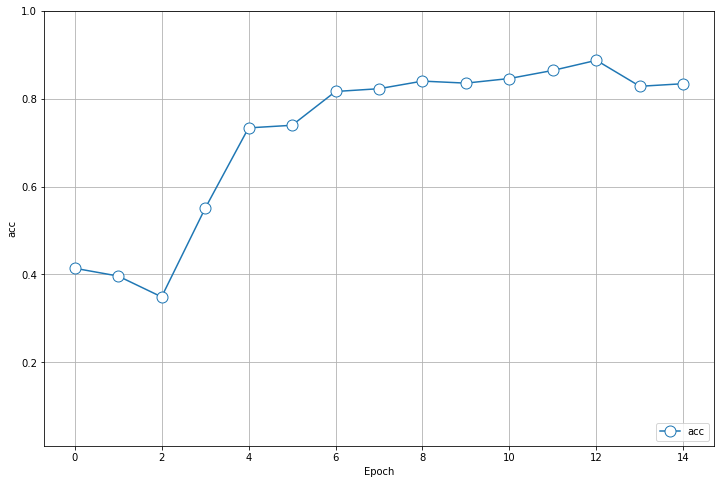

In [255]:
def plot_history(history, metrics_name, plot_validation, figsize = (12, 8)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(
        history[metrics_name], 
        label = metrics_name,
        marker = 'o',
        markersize = 11,
        markerfacecolor = 'white'
    )
    
    if plot_validation:
        plt.plot(
            history['val_' + metrics_name], 
            label = metrics_name + ' (validation)',
            marker = 'o',
            markersize = 11,
            markerfacecolor = 'white'
        )
    
    plt.xlabel('Epoch')
    plt.ylabel(metrics_name)
    plt.ylim([0.01, 1])
    plt.legend(loc = 'lower right')
    plt.grid()

plot_history(
    history = history.history,
    metrics_name = 'acc',
    plot_validation = False
)